# Car Price Prediction - Rusty Bargain

Rusty Bargain is a used car sales service that is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. They have provided access to historical data: technical specifications, trim versions, and prices. 

The goal is to build a model that will determine the value of a used car. Rusty Bargain is interested in:
- the quality of the prediction;
- the speed of the prediction;
- the time required for training.


## Data Preparation

### Loading the Packages and Data

In [112]:
import pandas as pd
import re
import datetime as dt
import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
try:
    df = pd.read_csv('datasets/car_data.csv')
except Exception:
    df = pd.read_csv('/datasets/car_data.csv')

In [3]:
sns.set_style('darkgrid')

### Initial Processing

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
def camel_to_snake(name):
    """Converts camel case to snake case using regex.

    Args:
        name (sting): the string to be converted.

    Returns:
        string: the converted string.
    """
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [6]:
# Convert column names to snake case
df.columns = [camel_to_snake(col) for col in df.columns]

In [7]:
# rename power column to horsepower
df.rename(columns={'power': 'horsepower'}, inplace=True)

In [8]:
df.head() # check the result

,date_crawled,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [9]:
df.info() # check for missing values and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   horsepower          354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [10]:
df.describe() # check for outliers and anomalies

,price,registration_year,horsepower,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [11]:
df.duplicated().sum() # check for duplicates

262

In [12]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [13]:
# drop unnecessary columns
df.drop([
    'date_crawled', 'number_of_pictures',
    'postal_code', 'last_seen', 
    'date_created', 'registration_month'
    ], axis=1, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354107 non-null  int64 
 1   vehicle_type       316623 non-null  object
 2   registration_year  354107 non-null  int64 
 3   gearbox            334277 non-null  object
 4   horsepower         354107 non-null  int64 
 5   model              334406 non-null  object
 6   mileage            354107 non-null  int64 
 7   fuel_type          321218 non-null  object
 8   brand              354107 non-null  object
 9   not_repaired       282962 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [15]:
df.describe()

,price,registration_year,horsepower,mileage
count,354107.000000,354107.000000,354107.000000,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684
std,4514.338584,90.261168,189.914972,37906.590101
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


The data is loaded and the initial processing is done. The data is checked for missing values and duplicates. The features that are not needed for the analysis are dropped. There are still some missing values in the data, and some outliers. The features will be processed further in the next section.

### Price Feature

In [16]:
df.price.describe()

count    354107.000000
mean       4416.433287
std        4514.338584
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

There are some outliers in the price feature, but no missing values. The maximum price in the data is 20,000 Euros, and the minimum price is 0 Euros. The low prices may not be realistic, but the high prices are realistic. The low prices may be due to the cars being very old, or the cars being damaged. In any case, the low prices may be detrimental to the model, as the typical user for a pricing app will not be trying to price a worthless automobile. The low prices will be examined further below.

Text(0.5, 1.0, 'Price distribution')

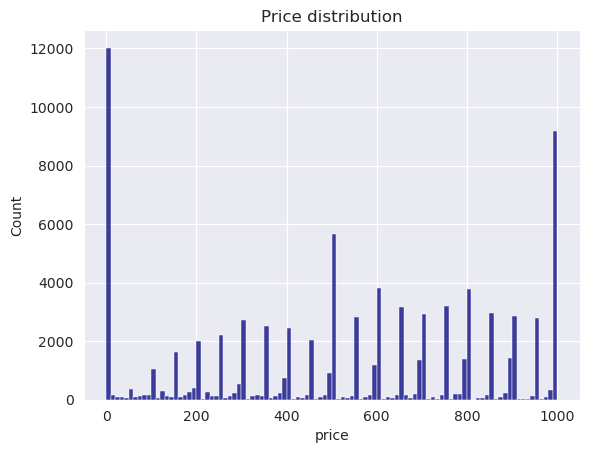

In [17]:
sns.histplot(df[df['price'] <= 1000], x='price', bins=100, color='navy').set_title('Price distribution')

In [191]:
# sample the vehicles with price less than 100
df[df['price'] <= 100].sample(10)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
144050,100,small,1998,auto,65,corsa,150000,petrol,opel,no
188810,99,small,1996,manual,54,punto,150000,petrol,fiat,no
245014,100,small,1998,manual,55,golf,150000,petrol,volkswagen,no
11882,100,small,1994,manual,52,twingo,150000,petrol,renault,yes
169256,100,small,1994,manual,50,fiesta,150000,petrol,ford,yes
172591,100,small,1997,manual,60,polo,150000,petrol,volkswagen,no
87858,100,small,1994,manual,54,twingo,150000,petrol,renault,yes
137013,100,sedan,1990,manual,136,90,150000,petrol,audi,no
83321,60,wagon,2002,manual,150,3er,5000,petrol,bmw,no
194210,100,wagon,2000,manual,145,v70,5000,petrol,volvo,no


In [ ]:
# number of vehicles with price less of zero
df[df['price'] <= 0].shape[0]

In [193]:
# sample the vehicles with price of 0
df[df['price'] < 1].sample(10)

ValueError: a must be greater than 0 unless no samples are taken

The vehicles with low prices will be removed from the data. Vehicle prices of zero may be due to an error in the listing, or zero may have been used to indicate listings with no price, or "make an offer" listings.

In [18]:
# drop rows with price <= 50
df = df[df['price'] > 50]

### Vehicle Type Feature

In [19]:
df.vehicle_type.describe()

count     308520
unique         8
top        sedan
freq       89072
Name: vehicle_type, dtype: object

In [20]:
df.vehicle_type.value_counts()

vehicle_type
sedan          89072
small          77596
wagon          63452
bus            28246
convertible    19796
coupe          15547
suv            11759
other           3052
Name: count, dtype: int64

Sedan is the most common type of vehicle. There are a lot of vehicles with other as the type, and many vehicles without a type. We will attempt to change some of the vehicle types of other to a more specific type, and find the type of vehicles that are missing a type.

In [ ]:
# if the vehicle type is other, find the most common type for that brand and model


In [21]:
# replace null values with most frequent value of matching brand and model
df.vehicle_type = df.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [22]:
df.head()

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,NaN,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341360 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              341360 non-null  int64 
 1   vehicle_type       324250 non-null  object
 2   registration_year  341360 non-null  int64 
 3   gearbox            324814 non-null  object
 4   horsepower         341360 non-null  int64 
 5   model              324250 non-null  object
 6   mileage            341360 non-null  int64 
 7   fuel_type          312785 non-null  object
 8   brand              341360 non-null  object
 9   not_repaired       276678 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.6+ MB


### Model Feature

In [24]:
df[df['model'].isnull()].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
245725,200,NaN,1992,manual,75,NaN,150000,petrol,opel,NaN
275822,950,NaN,2018,manual,90,NaN,125000,NaN,mitsubishi,NaN
120327,6500,NaN,2002,auto,346,NaN,150000,lpg,bmw,yes
343690,2700,NaN,2015,NaN,0,NaN,5000,NaN,sonstige_autos,NaN
331823,1100,NaN,1998,manual,0,NaN,150000,petrol,volkswagen,NaN
87663,1300,NaN,2016,NaN,0,NaN,150000,NaN,mazda,NaN
286324,1700,NaN,1991,auto,170,NaN,5000,petrol,sonstige_autos,no
240830,1050,NaN,1999,manual,54,NaN,150000,petrol,opel,no
197287,1600,NaN,1999,manual,101,NaN,150000,petrol,opel,no
251542,900,NaN,1998,auto,150,NaN,150000,NaN,audi,yes


In [25]:
# drop rows with null values in model column
df = df[df['vehicle_type'].notnull()]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324250 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              324250 non-null  int64 
 1   vehicle_type       324250 non-null  object
 2   registration_year  324250 non-null  int64 
 3   gearbox            310519 non-null  object
 4   horsepower         324250 non-null  int64 
 5   model              324250 non-null  object
 6   mileage            324250 non-null  int64 
 7   fuel_type          301289 non-null  object
 8   brand              324250 non-null  object
 9   not_repaired       266815 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.2+ MB


In [27]:
# get list of models with less than 100 entries
display(df.model.value_counts()[df.model.value_counts() < 100])

model
wrangler              99
q5                    97
kalos                 95
90                    93
citigo                91
g_klasse              91
navara                90
lanos                 86
mii                   81
discovery             78
range_rover           75
defender              74
911                   70
crossfire             64
glk                   63
cx_reihe              63
nubira                61
range_rover_sport     54
move                  51
lybra                 50
145                   45
croma                 45
v60                   42
terios                35
lodgy                 35
delta                 34
9000                  28
charade               27
b_max                 26
musa                  23
materia               18
200                   17
kappa                 14
amarok                13
q3                    13
gl                    12
samara                12
elefantino            11
kalina                 9
i3                 

In [28]:
# get percentage of other models
df[df['model'] == 'other'].shape[0] / df.shape[0]

0.07254587509637625

In [29]:
# drop other models
df = df[df['model'] != 'other']

### Year Feature

In [30]:
df.registration_year.describe()

count    300727.000000
mean       2004.070476
std          55.551118
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

<Axes: >

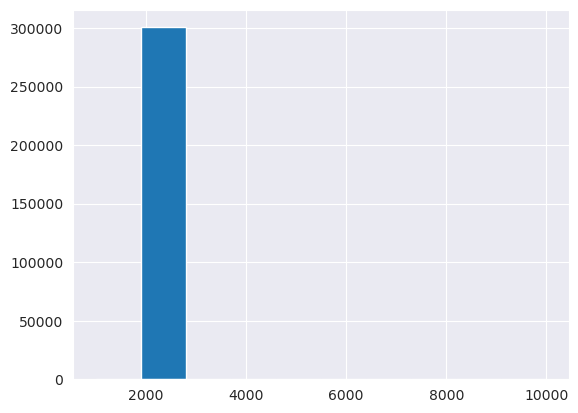

In [31]:
# plot histogram of registration year
df.registration_year.hist()

In [32]:
df[df['registration_year'] < 1950].registration_year.value_counts()

registration_year
1910    18
1000    10
1938     3
1500     2
1234     2
1923     2
1300     2
1945     1
1400     1
1936     1
1800     1
1600     1
Name: count, dtype: int64

In [33]:
display(df[df['registration_year'] <= 1900])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
16062,190,wagon,1000,NaN,0,mondeo,5000,NaN,ford,NaN
18224,7999,sedan,1500,manual,224,impreza,5000,NaN,subaru,NaN
53577,330,small,1000,NaN,0,polo,5000,NaN,volkswagen,NaN
56241,950,sedan,1400,manual,1400,golf,125000,petrol,volkswagen,NaN
71459,500,sedan,1000,NaN,0,golf,5000,NaN,volkswagen,NaN
97736,140,coupe,1000,NaN,0,911,5000,NaN,porsche,NaN
104698,100,wagon,1234,NaN,0,156,5000,petrol,alfa_romeo,NaN
121196,100,suv,1500,NaN,0,g_klasse,5000,NaN,mercedes_benz,NaN
129768,275,sedan,1234,NaN,0,e_klasse,5000,NaN,mercedes_benz,NaN
143621,550,sedan,1000,NaN,1000,golf,5000,petrol,volkswagen,NaN


In [34]:
df[df['registration_year'] > 2016].registration_year.value_counts()

registration_year
2017    8182
2018    3100
2019      15
9999       8
5000       8
7000       3
4000       3
2500       2
5555       2
5911       2
5900       1
2900       1
9000       1
8500       1
3700       1
2290       1
2066       1
3000       1
7100       1
2200       1
8200       1
Name: count, dtype: int64

In [35]:
display(df[df['registration_year'] == 2018])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
22,2900,bus,2018,manual,90,meriva,150000,petrol,opel,no
163,1200,sedan,2018,manual,75,astra,150000,NaN,opel,no
196,2800,small,2018,manual,75,twingo,125000,NaN,renault,no
355,1050,sedan,2018,NaN,0,golf,150000,NaN,volkswagen,NaN
390,3400,sedan,2018,NaN,0,astra,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
353824,2500,sedan,2018,manual,125,a_klasse,150000,petrol,mercedes_benz,no
353825,1600,small,2018,manual,0,lupo,5000,petrol,volkswagen,no
353918,999,sedan,2018,NaN,0,golf,150000,NaN,volkswagen,no
354203,2140,small,2018,manual,80,fiesta,150000,NaN,ford,no


In [36]:
# drop rows with registration year < 1900 or > 2016
df = df[df['registration_year'].between(1900, 2016)]

### Transmission Feature

In [37]:
df.gearbox.value_counts()

gearbox
manual    222948
auto       55140
Name: count, dtype: int64

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289372 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289372 non-null  int64 
 1   vehicle_type       289372 non-null  object
 2   registration_year  289372 non-null  int64 
 3   gearbox            278088 non-null  object
 4   horsepower         289372 non-null  int64 
 5   model              289372 non-null  object
 6   mileage            289372 non-null  int64 
 7   fuel_type          272141 non-null  object
 8   brand              289372 non-null  object
 9   not_repaired       240610 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [39]:
df[df['gearbox'].isnull()].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
269625,1100,sedan,2016,NaN,101,golf,150000,NaN,volkswagen,NaN
132040,1750,small,2001,NaN,50,polo,150000,petrol,volkswagen,no
341373,200,sedan,2016,NaN,0,megane,150000,petrol,renault,yes
269017,500,small,2003,NaN,0,twingo,150000,petrol,renault,no
307826,2990,wagon,2008,NaN,0,octavia,150000,gasoline,skoda,no
41488,100,small,2016,NaN,0,polo,150000,petrol,volkswagen,NaN
113737,7999,sedan,2008,NaN,105,golf,100000,gasoline,volkswagen,no
117029,100,small,2000,NaN,0,corsa,150000,NaN,opel,NaN
267990,2200,small,2004,NaN,41,fortwo,125000,gasoline,smart,no
208768,275,small,2002,NaN,55,punto,5000,petrol,fiat,NaN


In [40]:
display(df[df['model'] == 'other'].gearbox.value_counts())

Series([], Name: count, dtype: int64)

In [41]:
# assume that vehicles with null gearbox values are manual
df.gearbox = df.gearbox.fillna('manual')

In [42]:
df.horsepower.describe()

count    289372.000000
mean        112.848658
std         182.681370
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: horsepower, dtype: float64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289372 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289372 non-null  int64 
 1   vehicle_type       289372 non-null  object
 2   registration_year  289372 non-null  int64 
 3   gearbox            289372 non-null  object
 4   horsepower         289372 non-null  int64 
 5   model              289372 non-null  object
 6   mileage            289372 non-null  int64 
 7   fuel_type          272141 non-null  object
 8   brand              289372 non-null  object
 9   not_repaired       240610 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [44]:
df[df['horsepower'] < 20].horsepower.value_counts()

horsepower
0     25167
18       42
1        13
5        10
19        9
10        7
12        6
11        6
4         5
14        4
15        4
2         4
16        4
8         4
6         4
7         3
17        2
13        2
3         1
Name: count, dtype: int64

In [45]:
display(df[df['horsepower'] == 5])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
59478,999,convertible,1995,manual,5,punto,125000,petrol,fiat,no
78193,999,small,2000,manual,5,twingo,150000,petrol,renault,NaN
118004,6500,bus,2006,manual,5,5_reihe,150000,petrol,mazda,no
134171,1790,sedan,2002,manual,5,corsa,150000,petrol,opel,no
138316,360,small,1999,manual,5,twingo,150000,petrol,renault,NaN
146998,650,bus,1998,manual,5,kangoo,150000,petrol,renault,no
154878,500,small,2016,manual,5,lupo,150000,petrol,volkswagen,no
180367,700,small,2001,manual,5,polo,150000,petrol,volkswagen,no
186450,1990,small,2004,manual,5,fiesta,150000,petrol,ford,no
320484,1399,small,2001,manual,5,fortwo,125000,petrol,smart,no


In [46]:
df[df['horsepower'] == 0].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
57326,1250,wagon,2002,manual,0,v40,150000,gasoline,volvo,yes
240360,299,wagon,2000,manual,0,6_reihe,150000,petrol,mazda,NaN
289594,1150,small,1999,manual,0,twingo,150000,petrol,renault,no
79802,2200,sedan,2003,manual,0,astra,150000,petrol,opel,no
169530,990,sedan,1993,manual,0,80,150000,petrol,audi,NaN
28664,949,small,2001,manual,0,arosa,150000,petrol,seat,no
323895,4500,small,1983,manual,0,golf,150000,NaN,volkswagen,no
347642,1390,bus,2004,manual,0,scenic,150000,gasoline,renault,yes
315297,2799,sedan,2003,manual,0,scenic,5000,petrol,renault,no
219204,6150,sedan,2007,manual,0,a_klasse,125000,gasoline,mercedes_benz,NaN


In [47]:
# fill horsepower zero values with median non-zero horsepower of matching brand and model and year
df.horsepower = df.groupby(['brand', 'model', 'registration_year'])['horsepower'].transform(lambda x: x.replace(0, x[x > 0].median()))

# drop null horsepower values (which were zero before), then convert back to int
df.dropna(subset=['horsepower'], inplace=True)
df.horsepower = df.horsepower.astype('int')

In [48]:
df.describe()

,price,registration_year,horsepower,mileage
count,289118.000000,289118.000000,289118.000000,289118.00000
mean,4702.547918,2003.075329,121.766199,128912.31262
std,4547.312200,6.036812,179.945703,36470.86245
min,55.000000,1910.000000,1.000000,5000.00000
25%,1250.000000,1999.000000,75.000000,125000.00000
50%,2999.000000,2003.000000,110.000000,150000.00000
75%,6800.000000,2007.000000,145.000000,150000.00000
max,20000.000000,2016.000000,20000.000000,150000.00000


In [49]:
df[df['horsepower'] < 20].horsepower.value_counts()

horsepower
18    54
1     14
5     10
19     9
10     7
12     6
11     6
4      5
14     4
6      4
2      4
15     4
16     4
8      4
7      3
17     2
13     2
3      1
Name: count, dtype: int64

In [50]:
# drop rows with horsepower < 10
df = df[df['horsepower'] >= 10]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289073 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289073 non-null  int64 
 1   vehicle_type       289073 non-null  object
 2   registration_year  289073 non-null  int64 
 3   gearbox            289073 non-null  object
 4   horsepower         289073 non-null  int64 
 5   model              289073 non-null  object
 6   mileage            289073 non-null  int64 
 7   fuel_type          271968 non-null  object
 8   brand              289073 non-null  object
 9   not_repaired       240478 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [52]:
display(df[df['horsepower'] > 600])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [53]:
# if horsepower > 600, replace with median horsepower of matching brand and model
df.horsepower = df.groupby(['brand', 'model'])['horsepower'].transform(lambda x: x.replace(x[x > 600].median()))

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289073 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289073 non-null  int64 
 1   vehicle_type       289073 non-null  object
 2   registration_year  289073 non-null  int64 
 3   gearbox            289073 non-null  object
 4   horsepower         289073 non-null  int64 
 5   model              289073 non-null  object
 6   mileage            289073 non-null  int64 
 7   fuel_type          271968 non-null  object
 8   brand              289073 non-null  object
 9   not_repaired       240478 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [55]:
display(df[df['horsepower'] > 600])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
6637,600,small,1996,manual,603,corsa,150000,petrol,opel,yes
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN
8057,500,small,2002,manual,620,ypsilon,150000,petrol,lancia,NaN
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [56]:
# drop rows with horsepower > 600
df = df[df['horsepower'] <= 600]

In [57]:
df.horsepower.describe()

count    288879.000000
mean        118.543806
std          52.089662
min          10.000000
25%          75.000000
50%         110.000000
75%         145.000000
max         600.000000
Name: horsepower, dtype: float64

In [58]:
df.fuel_type.value_counts()

fuel_type
petrol      180558
gasoline     86474
lpg           4076
cng            472
hybrid         123
other           85
electric        25
Name: count, dtype: int64

In [59]:
display(df[df['fuel_type'].isnull()])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN
54,4700,wagon,2005,manual,155,signum,150000,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...
354327,2999,wagon,2004,manual,234,vectra,100000,NaN,opel,NaN
354329,350,small,1996,manual,65,punto,150000,NaN,fiat,NaN
354339,3850,convertible,2006,manual,108,2_reihe,125000,NaN,peugeot,no
354346,2600,sedan,2005,auto,150,c_klasse,150000,NaN,mercedes_benz,NaN


In [60]:
# replace gasoline with petrol
df.fuel_type = df.fuel_type.replace('gasoline', 'petrol')

In [61]:
# replace null values in fuel type with most frequent value of matching brand and model
df.fuel_type = df.groupby(['brand', 'model'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288879 non-null  int64 
 1   vehicle_type       288879 non-null  object
 2   registration_year  288879 non-null  int64 
 3   gearbox            288879 non-null  object
 4   horsepower         288879 non-null  int64 
 5   model              288879 non-null  object
 6   mileage            288879 non-null  int64 
 7   fuel_type          288879 non-null  object
 8   brand              288879 non-null  object
 9   not_repaired       240363 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.2+ MB


In [63]:
df.not_repaired.value_counts()

not_repaired
no     212564
yes     27799
Name: count, dtype: int64

In [64]:
df.not_repaired = df.not_repaired.fillna('no')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288879 non-null  int64 
 1   vehicle_type       288879 non-null  object
 2   registration_year  288879 non-null  int64 
 3   gearbox            288879 non-null  object
 4   horsepower         288879 non-null  int64 
 5   model              288879 non-null  object
 6   mileage            288879 non-null  int64 
 7   fuel_type          288879 non-null  object
 8   brand              288879 non-null  object
 9   not_repaired       288879 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.2+ MB


In [66]:
# show the sorted unique values of the model column
df.model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [67]:
%%time
# show number of other models
print(df[df['model'] == 'other'].model.count())

0
CPU times: user 9.8 ms, sys: 0 ns, total: 9.8 ms
Wall time: 9.65 ms


In [68]:
# remove other models
df = df[df['model'] != 'other']

In [69]:
df.brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

In [70]:
# reset index
df.reset_index(drop=True, inplace=True)

In [71]:
df.mileage.describe()

count    288879.000000
mean     128915.116710
std       36463.602656
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: mileage, dtype: float64

<Axes: >

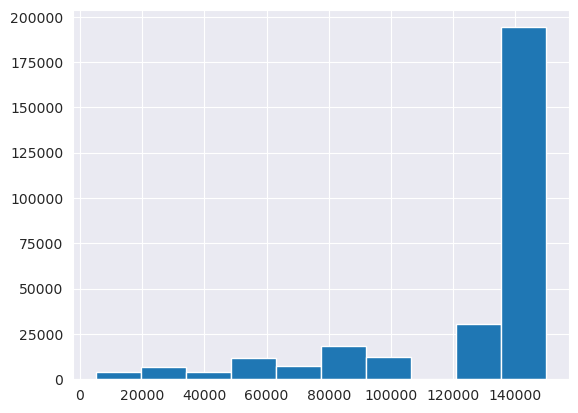

In [72]:
df.mileage.hist()

In [73]:
df.mileage.value_counts()

mileage
150000    194168
125000     30545
100000     12193
90000       9823
80000       8498
70000       7284
60000       6374
50000       5263
40000       4167
30000       3606
5000        3145
20000       3015
10000        798
Name: count, dtype: int64

/home/jonathan/anaconda3/envs/data_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


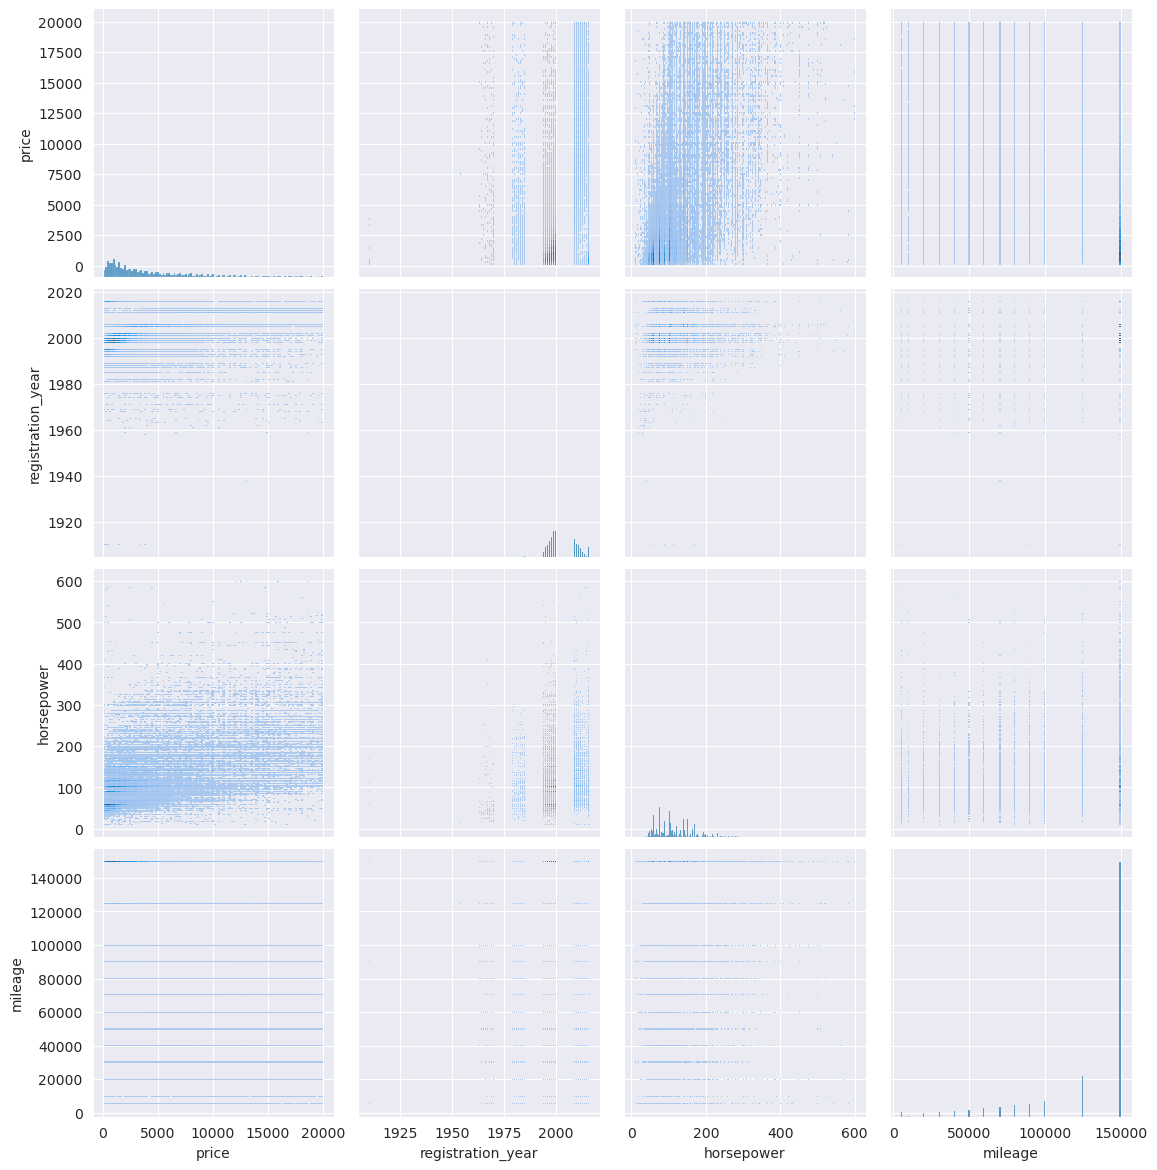

In [74]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12,12)

## Creating the models

In [75]:
random_state = 12345

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288879 entries, 0 to 288878
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288879 non-null  int64 
 1   vehicle_type       288879 non-null  object
 2   registration_year  288879 non-null  int64 
 3   gearbox            288879 non-null  object
 4   horsepower         288879 non-null  int64 
 5   model              288879 non-null  object
 6   mileage            288879 non-null  int64 
 7   fuel_type          288879 non-null  object
 8   brand              288879 non-null  object
 9   not_repaired       288879 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.0+ MB


In [77]:
df.sample(10)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
75074,1200,sedan,1990,auto,75,kadett,80000,petrol,opel,no
144627,3790,sedan,2004,auto,125,astra,150000,petrol,opel,no
165911,9450,sedan,2009,manual,125,leon,100000,petrol,seat,no
226821,4399,sedan,2004,manual,75,golf,100000,petrol,volkswagen,no
278242,5990,wagon,2009,manual,86,fabia,100000,petrol,skoda,no
37752,1999,sedan,1997,auto,170,5er,150000,petrol,bmw,no
57540,6800,wagon,2010,manual,170,passat,150000,petrol,volkswagen,no
643,9000,sedan,2008,manual,140,a3,150000,petrol,audi,no
94201,1899,sedan,2001,manual,150,golf,150000,petrol,volkswagen,no
23432,2499,sedan,2001,manual,101,golf,150000,petrol,volkswagen,no


In [78]:
# split data into features and target (price)
features = df.drop('price', axis=1)
target = df.price

In [79]:
# Split data into training, validation, and test sets (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, target, test_size=0.4, random_state=random_state
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_state
)

# Print the sizes of the datasets
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_valid.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target training set size: {y_train.shape[0]}')
print(f'Target validation set size: {y_valid.shape[0]}')
print(f'Target test set size: {y_test.shape[0]}')
print(f'Total: {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]}')

Training set size: 173327
Validation set size: 57776
Test set size: 57776
Target training set size: 173327
Target validation set size: 57776
Target test set size: 57776
Total: 288879


In [80]:
# create lists of numeric and categorical features
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
numeric_features = ['registration_year', 'mileage', 'horsepower']

In [81]:
# create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# create pipeline for numeric features
numeric_transformer = 'passthrough'

# create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])



### Linear Regression

In [113]:
# create the linear regression model
start = time.process_time()
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# fit the model to the training data
model_lr.fit(X_train, y_train)
time_lr = time.process_time() - start

# make predictions on the validation set and score using RMSE
y_pred_lr = model_lr.predict(X_valid)
rmse_lr = mean_squared_error(y_valid, y_pred_lr, squared=False)

print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Linear Regression time: {time_lr:.2f} seconds')

Linear Regression RMSE: 2737.43
Linear Regression time: 0.87


### Random Forest

In [145]:
# create the random forest model
start_rf = time.perf_counter()
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=random_state))
])

# Define the hyperparameters to tune
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 10, 15],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 5]
}

# Perform a grid search with cross-validation to find the best hyperparameters
random_search = RandomizedSearchCV(
    model_rf, 
    param_grid, 
    cv=5, n_iter=8, 
    scoring='neg_root_mean_squared_error', 
    verbose=1,
    random_state=random_state
)
random_search.fit(X_train, y_train)
time_rf = time.perf_counter() - start_rf

# get the best hyperparameters
best_params_rf = random_search.best_params_
best_rf_model = random_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Random Forest hyperparameters: {best_params_rf}')
y_pred_rf = best_rf_model.predict(X_valid)
rmse_rf = mean_squared_error(y_valid, y_pred_rf, squared=False)
print(f'Random Forest RMSE: {rmse_rf:.2f}')
print(f'Random Forest time: {time_rf:.2f} seconds')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Random Forest hyperparameters: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 15}
Random Forest RMSE: 1613.41
Random Forest time: 5493.15 seconds


In [ ]:
# copy of the random forest model but with n_jobs=-2


### Decision Tree

In [146]:
# create the decision tree model
start_dt = time.perf_counter()
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=random_state))
])

# Define the hyperparameters to tune
param_grid = {
    'regressor__max_depth': [3, 6, 9, 12, 15, 18, 24, 27, 30],
    'regressor__min_samples_split': [2, 5, 10, 15],
    'regressor__min_samples_leaf': [1, 2, 5, 10]
}

# Perform a grid search with cross-validation to find the best hyperparameters
random_search = RandomizedSearchCV(
    model_dt, 
    param_grid, 
    cv=5, n_iter=50, 
    scoring='neg_root_mean_squared_error', 
    verbose=1,
    random_state=random_state
)
random_search.fit(X_train, y_train)
time_dt = time.perf_counter() - start_dt

# get the best hyperparameters
best_params_dt = random_search.best_params_
best_dt_model = random_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Decision Tree hyperparameters: {best_params_dt}')
y_pred_dt = best_dt_model.predict(X_valid)
rmse_dt = mean_squared_error(y_valid, y_pred_dt, squared=False)
print(f'Random Forest RMSE: {rmse_dt:.2f}')
print(f'Random Forest time: {time_dt:.2f} seconds')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Decision Tree hyperparameters: {'regressor__min_samples_split': 15, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 27}
Random Forest RMSE: 1653.25
Random Forest time: 590.43 seconds


### LightGBM

In [149]:
# create the lightGBM model
start_lgbm = time.perf_counter()
model_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(force_row_wise=True, verbosity=-1, random_state=random_state))
])

# Define the hyperparameters to tune
param_grid = {
    'regressor__max_depth': [5, 10, 15, 20],
    'regressor__num_leaves': [50, 100, 200, 300, 400],
    'regressor__min_data_in_leaf': [20, 50, 100],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
}

# Perform a grid search with cross-validation to find the best hyperparameters
random_search = RandomizedSearchCV(
    model_lgbm, 
    param_distributions=param_grid, 
    cv=5, n_iter=50, 
    scoring='neg_root_mean_squared_error', 
    verbose=1,
    random_state=random_state
)
random_search.fit(X_train, y_train)
time_lgbm = time.perf_counter() - start_lgbm

# get the best hyperparameters
best_params_lgbm = random_search.best_params_
best_lgbm_model = random_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Decision Tree hyperparameters: {best_params_lgbm}')
y_pred_lgbm = best_lgbm_model.predict(X_valid)
rmse_lgbm = mean_squared_error(y_valid, y_pred_lgbm, squared=False)
print(f'Random Forest RMSE: {rmse_lgbm:.2f}')
print(f'LightGBM training time: {time_lgbm:.8f} seconds')



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Decision Tree hyperparameters: {'regressor__num_leaves': 300, 'regressor__min_data_in_leaf': 20, 'regressor__max_depth': 15, 'regressor__learning_rate': 0.2}
Random Forest RMSE: 1493.03
LightGBM training time: 141.95571184 seconds


### XGBoost

In [150]:
# create the xgboost model
start_xgb = time.perf_counter()
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=random_state, verbosity=0))
])

# Define the hyperparameters to tune
param_grid = {
    'regressor__n_estimators': [100, 150, 200, 250, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [5, 8, 10],
    'regressor__min_child_weight': [1, 5, 10]
}

# Perform a grid search with cross-validation to find the best hyperparameters
random_search = RandomizedSearchCV(
    model_xgb, 
    param_grid, 
    cv=5, n_iter=50, 
    scoring='neg_root_mean_squared_error', 
    verbose=1
)
random_search.fit(X_train, y_train)
time_xgb = time.perf_counter() - start_xgb

# get the best hyperparameters
best_params_xgb = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best XGBoost hyperparameters: {best_params_xgb}')
y_pred_xgb = best_xgb_model.predict(X_valid)
rmse_xgb = mean_squared_error(y_valid, y_pred_xgb, squared=False)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')
print(f'XGBoost training time: {time_xgb:.8f} seconds')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost hyperparameters: {'regressor__n_estimators': 250, 'regressor__min_child_weight': 5, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.2}
XGBoost RMSE: 1481.75
XGBoost training time: 526.29416918 seconds


### CatBoost


In [151]:
# create the catboost model
start_cat = time.perf_counter()
model_cat = CatBoostRegressor(cat_features=categorical_features, random_state=random_state, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'iterations': [100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'depth': [5, 10],
    'l2_leaf_reg': [2, 4, 6, 8, 10]
}

# Perform a grid search with cross-validation to find the best hyperparameters
random_search = RandomizedSearchCV(
    model_cat, 
    param_grid, 
    cv=5, n_iter=50, 
    scoring='neg_root_mean_squared_error', 
    verbose=1)
random_search.fit(X_train, y_train)
time_cat = time.perf_counter() - start_cat

# get the best hyperparameters
best_params_cat = random_search.best_params_
best_cat_model = random_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best CatBoost hyperparameters: {best_params_cat}')
y_pred_cat = best_cat_model.predict(X_valid)
rmse_cat = mean_squared_error(y_valid, y_pred_cat, squared=False)
print(f'CatBoost RMSE: {rmse_cat:.2f}')
print(f'CatBoost training time: {time_cat:.8f} seconds')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CatBoost hyperparameters: {'learning_rate': 0.5, 'l2_leaf_reg': 8, 'iterations': 300, 'depth': 10}
CatBoost RMSE: 1508.83
CatBoost training time: 738.88577479 seconds


### Model Evaluation

In [158]:
def apply_model_performance(model, model_name, X_test, y_test):
    """Applies the given model to the test set and returns the RMSE and time taken.

    Args:
        model (sklearn model): the model to be applied.
        model_name (string): the name of the model.
        X_test (pandas dataframe): the test features.
        y_test (pandas series): the test target.

    Returns:
        tuple: a tuple containing the RMSE and time taken.
    """
    start = time.perf_counter()
    y_pred = model.predict(X_test)
    time_taken = time.perf_counter() - start
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse, time_taken

In [153]:
# create a dataframe of the model names, their RMSE scores, and their training times
models_compare = pd.DataFrame({
    #'training_time' : [0.274, 713, 627, 45.8, 192, 321],
    'training_time' : [time_lr, time_rf, time_dt, time_lgbm, time_xgb, time_cat],
    'validation_rmse' : [rmse_lr, rmse_rf, rmse_dt, rmse_lgbm, rmse_xgb, rmse_cat]
    },
    index=['Linear Regression', 'Random Forest', 'Decision Tree', 'LightGBM', 'XGBoost', 'CatBoost'])


In [159]:
# apply the best model of each type to the test set, get the RMSE, average time taken, and add to the dataframe
num_iterations = 10
for i, model in enumerate([model_lr, best_rf_model, best_dt_model, best_lgbm_model, best_xgb_model, best_cat_model]):
    rmse_list = []
    time_list = []
    for _ in range(num_iterations):
        rmse, time_taken = apply_model_performance(model, models_compare.index[i], X_test, y_test)
        rmse_list.append(rmse)
        time_list.append(time_taken)
    
    models_compare.loc[models_compare.index[i], 'test_rmse'] = sum(rmse_list) / num_iterations
    models_compare.loc[models_compare.index[i], 'prediction_time'] = sum(time_list) / num_iterations

In [160]:
display(models_compare)
models_compare.to_csv('datasets/models_compare.csv')

,training_time,validation_rmse,test_rmse,prediction_time
Linear Regression,0.872031,2737.426427,2755.534723,0.046556
Random Forest,5493.151660,1613.414415,1639.072535,0.436328
Decision Tree,590.429447,1653.254394,1678.975063,0.051552
LightGBM,141.955712,1493.030178,1522.396517,0.076133
XGBoost,526.294169,1481.747962,1507.400060,0.095067
CatBoost,738.885775,1508.828596,1536.682532,0.046874


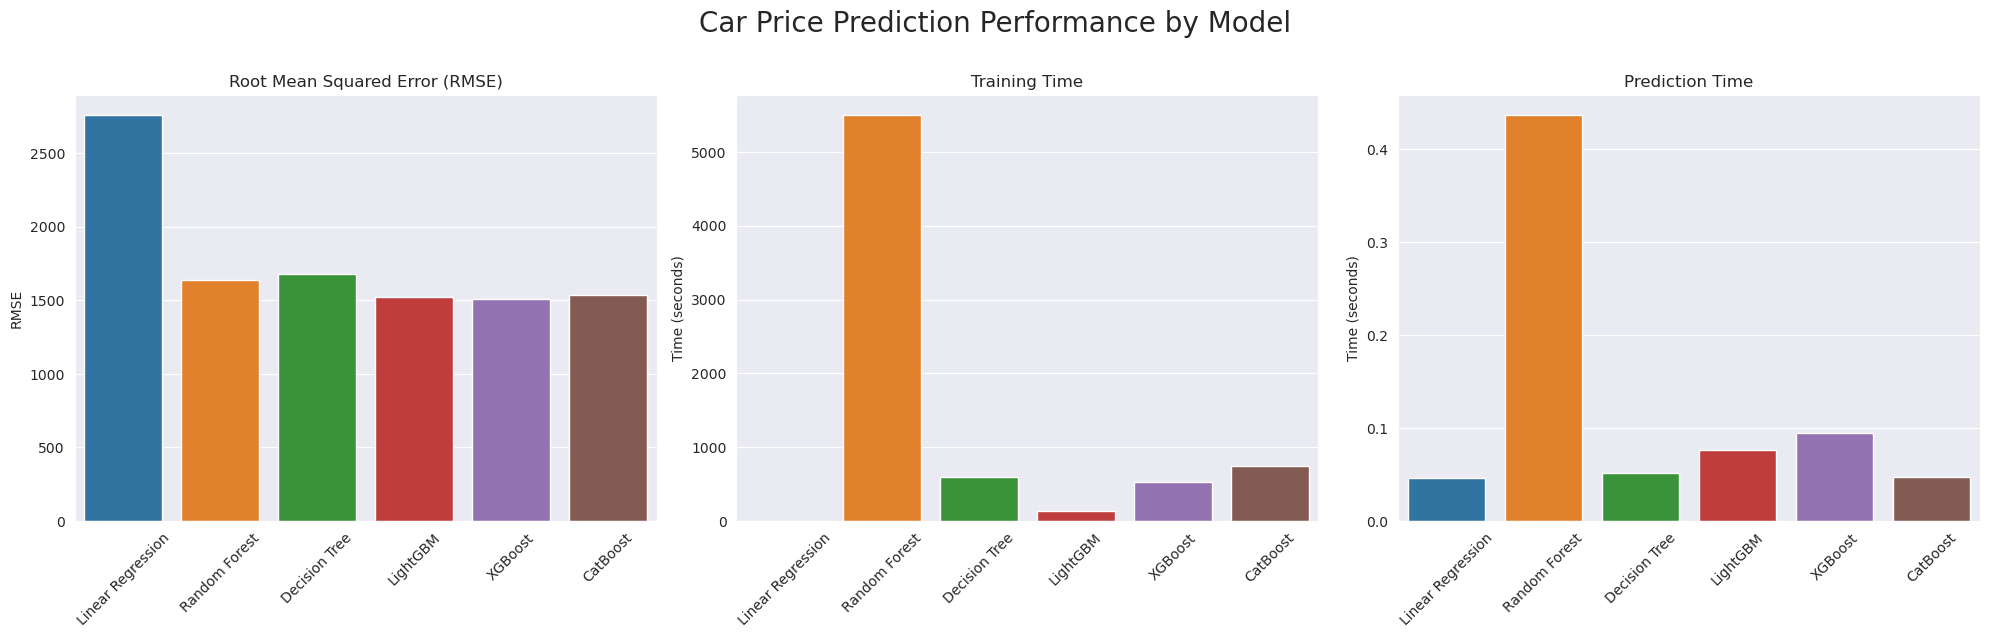

In [189]:
# plot the results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# plot the RMSE scores
sns.barplot(x=models_compare.index, y=models_compare.test_rmse, ax=axes[0])
axes[0].set_title('Root Mean Squared Error (RMSE)')
axes[0].set_ylabel('RMSE')

# plot the training times
sns.barplot(x=models_compare.index, y=models_compare.training_time, ax=axes[1])
axes[1].set_title('Training Time')
axes[1].set_ylabel('Time (seconds)')

# plot the prediction times
sns.barplot(x=models_compare.index, y=models_compare.prediction_time, ax=axes[2])
axes[2].set_title('Prediction Time')
axes[2].set_ylabel('Time (seconds)')

# adjust the layout
plt.tight_layout()

# rotate the x-axis ticks labels and bold them
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    
# Add an overall title for the plots and make it bold
fig.suptitle('Car Price Prediction Performance by Model', fontsize=20, y=1.1)

# show the plot
plt.show()

### Applying the model to the test data

## Conclusion

## Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed